# **block2vec**

## Why block2vec

To make blocks continuous so that backprop is possible, we use vector representation of blocks rather than descrete block types. inspired by word2vec [cite], we use a similar technique called block2vec proposed in [world gan paper]. 

World GAN and block2vec code: https://github.com/Mawiszus/World-GAN

In [1]:
# import stuff
import data_helper
import visualise_helper
import numpy as np

import importlib
importlib.reload(visualise_helper)
importlib.reload(data_helper)

<module 'data_helper' from '/Users/leonlu-m1/Documents/Python Programming/3D-GANCA/data_helper.py'>

In [2]:
trainx_df = data_helper.all_trainx_as_df()

  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses


In [3]:
trainx_df.head(3)

,world,dir,Size,Num unique IDs,Num unique blocks,Percentage air untrimmed,Percentage air trimmed
0,"[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...",workdir.2018-08-27-02:34:57.ip-172-31-11-175,23.0,4.0,7.0,0.955618,0.720497
1,"[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...",workdir.2018-08-26-18:49:04.ip-172-31-10-229,15.0,13.0,21.0,0.789630,0.561728
2,"[[[[0 0], [0 0], [0 0], [0 0], [0 0], [0 0], [...",workdir.2018-08-28-02:26:04.ip-172-31-14-122,9.0,9.0,16.0,0.786008,0.646259


  0%|          | 0/3 [00:00<?, ?it/s]

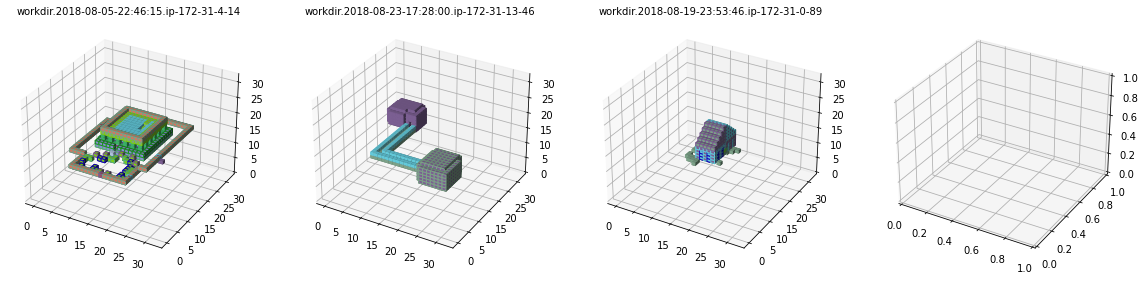

In [4]:
visualise_helper.visualise_world(trainx_df.sample(3))

## A giant mess

In [1]:
import sys
from loguru import logger
logger.add(sys.stdout, colorize=True, format="<blue>{time}</blue> <level>{message}</level>")
logger.level("INFO", color="<red><bold>")
%load_ext tensorboard

In [2]:
# Block2VecDataset

import os
from collections import defaultdict
from itertools import product
from typing import Tuple

import numpy as np
from tqdm.notebook import tqdm

from pyanvileditor.world import World
from torch.utils.data.dataset import Dataset

class Block2VecDataset(Dataset):

    def __init__(self, input_world_path: str, coords: Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]], cutout_coords: bool,  neighbor_radius: int = 1):
        """Block dataset with configurable neighborhood radius.

        Args:
            input_world_path (str): path to the Minecraft world
            coords (Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]]): x, y, z coordinates of extracted region
            neighbor_radius (int): neighbors to retrieve as a context
        """
        super().__init__()
        self.input_world_path = input_world_path
        self.world = World(os.path.basename(input_world_path),
                           save_location=os.path.abspath(os.path.dirname(input_world_path)), write=False, debug=False)
        self.x_lims, self.y_lims, self.z_lims = coords if cutout_coords else self._read_size()
        padding = 2 * neighbor_radius  # one token on each side
        logger.info("Coord limits x: [{}, {}], y: [{}, {}], z: [{}, {}]", self.x_lims[0],self.x_lims[1],self.y_lims[0],self.y_lims[1],self.z_lims[0],self.z_lims[1])
        self.x_dim = self.x_lims[1] - self.x_lims[0] - padding
        self.y_dim = self.y_lims[1] - self.y_lims[0] - padding
        self.z_dim = self.z_lims[1] - self.z_lims[0] - padding
        logger.info("Cutting {} x {} x {} volume from {}", self.x_dim,
                    self.y_dim, self.z_dim, self.input_world_path)
        self.neighbor_radius = neighbor_radius
        self._read_blocks()
        self._init_discards()

    def _init_discards(self):
        t = 0.001
        token_frequencies = list(self.block_frequency.values())
        f = np.array(token_frequencies) / sum(token_frequencies)
        self.discards = 1.0 - (np.sqrt(f / t) + 1) * (t / f)

    def _read_size(self):
        regions = os.listdir(self.world.world_folder / 'region')
        arr_regions = np.zeros((len(regions), 2))
        for i, r in enumerate(regions):
            name = r.split(".")
            rx = int(name[1])
            rz = int(name[2])
            arr_regions[i] = rx, rz
        igno_border = 0
        x_lims = [int((min(arr_regions[:, 0]) * 32 * 16) + igno_border),
                  int((max(arr_regions[:, 0]) * 32 * 16) - igno_border)]
        z_lims = [int((min(arr_regions[:, 1]) * 32 * 16) + igno_border),
                  int((max(arr_regions[:, 1]) * 32 * 16) - igno_border)]
        y_lims = [0, 256]
        return x_lims, y_lims, z_lims

    def _read_blocks(self):
        self.block_frequency = defaultdict(int)
        coordinates = [(x, y, z) for x, y, z in product(range(self.x_lims[0], self.x_lims[1] + 1),
                                                        range(self.y_lims[0], self.y_lims[1] + 1), range(self.z_lims[0], self.z_lims[1] + 1))]
        logger.info("Collecting {} blocks", len(self))
        for name in tqdm([self._get_block(*coord) for coord in coordinates]):
            self.block_frequency[name] += 1
        logger.info(
            "Found the following blocks {blocks}", blocks=dict(self.block_frequency))
        self.block2idx = dict()
        self.idx2block = dict()
        for name, count in self.block_frequency.items():
            block_idx = len(self.block2idx)
            self.block2idx[name] = block_idx
            self.idx2block[block_idx] = name

    def __getitem__(self, index):
        coords = self._idx_to_coords(index)
        block = self._get_block(*coords)
        target = self.block2idx[block]
        if np.random.rand() < self.discards[target]:
            return self.__getitem__(np.random.randint(self.__len__()))
        neighbor_blocks = self._get_neighbors(*coords)
        context = np.array([self.block2idx[n] for n in neighbor_blocks])
        return target, context

    def _idx_to_coords(self, index):
        z = index % (self.z_dim + 1)
        y = int(((index - z) / (self.z_dim + 1)) % (self.y_dim + 1))
        x = int(((index - z) / (self.z_dim + 1) - y) / (self.y_dim + 1))
        x += self.x_lims[0] + self.neighbor_radius
        y += self.y_lims[0] + self.neighbor_radius
        z += self.z_lims[0] + self.neighbor_radius
        return x, y, z

    def _get_block(self, x, y, z):
        # print(x,y,z)
        block = self.world.get_block([x, y, z])
        name = block.get_state().name
        return name

    def _get_neighbors(self, x, y, z):
        neighbor_coords = [(x + x_diff, y + y_diff, z + z_diff) for x_diff, y_diff, z_diff in product(list(
            range(-self.neighbor_radius, self.neighbor_radius + 1)), repeat=3) if x_diff != 0 or y_diff != 0 or z_diff != 0]
        return [self._get_block(*coord) for coord in neighbor_coords]

    def __len__(self):
        return self.x_dim * self.y_dim * self.z_dim

In [3]:
# SkipGramModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

class SkipGramModel(nn.Module):
    def __init__(self, emb_size: int, emb_dimension: int):
        super().__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.target_embeddings = nn.Embedding(emb_size, emb_dimension)
        self.output = nn.Linear(emb_dimension, emb_size)

        initrange = 1.0 / self.emb_dimension
        init.uniform_(self.target_embeddings.weight.data, -
                      initrange, initrange)

    def forward(self, target, context):
        emb_target = self.target_embeddings(target)

        score = self.output(emb_target)
        score = F.log_softmax(score, dim=-1)

        losses = torch.stack([F.nll_loss(score, context_word)
                              for context_word in context.transpose(0, 1)])
        return losses.mean()

In [4]:
# ImageAnnotations3D

from typing import List
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import proj3d, Axes3D
from matplotlib import offsetbox
import numpy as np


class ImageAnnotations3D:
    def __init__(self, xyz, imgs: List[np.ndarray], labels: List[str], ax3d: Axes3D, figure: Figure):
        self.xyz = xyz
        self.imgs = imgs
        self.labels = labels
        self.ax3d = ax3d
        self.figure = figure
        self.annot = []
        for xyz, im, label in zip(self.xyz, self.imgs, self.labels):
            x, y = self.proj(xyz)
            self.annot.append(self.image(im, [x, y]))
            self.annot.append(self.label(label, [x, y]))
        self.lim = self.ax3d.get_w_lims()
        self.rot = self.ax3d.get_proj()
        self.cid = self.ax3d.figure.canvas.mpl_connect(
            "draw_event", self.update)

        self.funcmap = {"button_press_event": self.ax3d._button_press,
                        "motion_notify_event": self.ax3d._on_move,
                        "button_release_event": self.ax3d._button_release}

        self.cfs = [self.ax3d.figure.canvas.mpl_connect(kind, self.cb)
                    for kind in self.funcmap.keys()]

    def cb(self, event):
        event.inaxes = self.ax3d
        self.funcmap[event.name](event)

    def proj(self, X):
        """ From a 3D point in axes ax1, 
            calculate position in 2D in ax2 """
        x, y, z = X
        x2, y2, _ = proj3d.proj_transform(x, y, z, self.ax3d.get_proj())
        return x2, y2

    def image(self, arr, xy):
        """ Place an image (arr) as annotation at position xy """
        im = offsetbox.OffsetImage(arr)
        ab = offsetbox.AnnotationBbox(im, xy, pad=0)
        self.ax3d.add_artist(ab)
        return ab

    def label(self, label, xy):
        text = offsetbox.TextArea(label, minimumdescent=False)
        ab = offsetbox.AnnotationBbox(text, xy,
                                      xybox=(0, 16),
                                      xycoords='data',
                                      boxcoords="offset points")
        self.ax3d.add_artist(ab)
        return ab

    def update(self, event):
        if np.any(self.ax3d.get_w_lims() != self.lim) or \
                np.any(self.ax3d.get_proj() != self.rot):
            self.lim = self.ax3d.get_w_lims()
            self.rot = self.ax3d.get_proj()
            for s, ab in zip(self.xyz, self.annot):
                ab.xy = self.proj(s)

In [5]:
# SAMPLE_COORDS
import pickle

def load_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

SAMPLE_COORDS = load_pkl("primordial_coords_dict.pkl")

In [6]:
# Block2VecArgs

import math
import os
import pickle
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.optim as optim
from fuzzywuzzy import process
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import DataLoader
import umap

MC_WORLD_DIR = 'dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL' # 'dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL', 'dataset/minecraft_worlds/1_17 m1 test'


class Block2VecArgs:
    
    # the input world?
    input_world_path: str = os.path.abspath(MC_WORLD_DIR)
    
    # output path?
    output_path: str = os.path.join("output", "block2vec")
    emb_dimension: int = 32
    epochs: int = 30
    batch_size: int = 256 # was 256
    initial_lr: float = 1e-3
    world_coords_name: str = "ruins"
    output_path = os.path.join(output_path, world_coords_name)
    input_world_coords: Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]] = (
        (1028, 1028 + 10),
        (60, 60 + 10),
        (1088, 1088 + 10),
    )
    # input_world_coords: Tuple[Tuple[int, int], Tuple[int, int], Tuple[int, int]] = (
    #     (16, 32),
    #     (16, 32),
    #     (16, 32),
    # )
    
    # input_world_coords = SAMPLE_COORDS[world_coords_name] # use the world_coords_name to key out coord
    
    cutout_coords: bool = True # use input_world_coords rather than the whole world 
    neighbor_radius: int = 1

    logger.info(output_path)

2022-02-10 21:55:55.802 | INFO     | __main__:Block2VecArgs:54 - output/block2vec/ruins


2022-02-10T21:55:55.802592+0800 output/block2vec/ruins


In [7]:
testargs = Block2VecArgs()

In [8]:
testargs.input_world_coords

((1028, 1038), (60, 70), (1088, 1098))

In [9]:
class Block2Vec(pl.LightningModule):
    def __init__(self, block2vec_args: Block2VecArgs):
        super().__init__()
        self.args: Block2VecArgs = block2vec_args
        self.save_hyperparameters()
        self.dataset = Block2VecDataset(
            self.args.input_world_path,
            coords=self.args.input_world_coords,
            cutout_coords=self.args.cutout_coords,
            neighbor_radius=self.args.neighbor_radius,
        )
        self.emb_size = len(self.dataset.block2idx)
        self.model = SkipGramModel(self.emb_size, self.args.emb_dimension)
        self.textures = dict()
        self.learning_rate = self.args.initial_lr

    def forward(self, *args, **kwargs) -> torch.Tensor:
        return self.model(*args, **kwargs)

    def training_step(self, batch, *args, **kwargs):
        logger.info("doing a training step")
        loss = self.forward(*batch)
        self.log("loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            math.ceil(len(self.dataset) / self.args.batch_size) *
            self.args.epochs,
        )
        return [optimizer], [scheduler]

    def train_dataloader(self) -> DataLoader:
        logger.info("data loading")
        return DataLoader(
            self.dataset,
            batch_size=self.args.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=os.cpu_count() or 1,
        )

    def on_epoch_end(self):
        print('on_epoch_end')
        embedding_dict = self.save_embedding(
            self.dataset.idx2block, self.args.output_path
        )
        self.create_confusion_matrix(
            self.dataset.idx2block, self.args.output_path)
        self.plot_embeddings(embedding_dict, self.args.output_path)

    def read_texture(self, block: str):
        if block not in self.textures and block != "air":
            texture_candidates = Path(
                "/home/schubert/projects/TOAD-GAN/minecraft/block2vec/textures"
            ).glob("*.png")
            # use of absolute path is intentional
            match = process.extractOne(block, texture_candidates)
            if match is not None:
                logger.info("Matches {} with {} texture file", block, match[0])
                self.textures[block] = plt.imread(match[0])
        if block not in self.textures:
            self.textures[block] = np.ones(shape=[16, 16, 3])
        return self.textures[block]

    def save_embedding(self, id2block: Dict[int, str], output_path: str):
        embeddings = self.model.target_embeddings.weight
        # embeddings = embeddings / torch.norm(embeddings, p=2, dim=-1, keepdim=True)
        embeddings = embeddings.cpu().data.numpy()
        embedding_dict = {}
        with open(os.path.join(output_path, "embeddings.txt"), "w") as f:
            f.write("%d %d\n" % (len(id2block), self.args.emb_dimension))
            for wid, w in id2block.items():
                e = " ".join(map(lambda x: str(x), embeddings[wid]))
                embedding_dict[w] = torch.from_numpy(embeddings[wid])
                f.write("%s %s\n" % (w, e))
        np.save(os.path.join(output_path, "embeddings.npy"), embeddings)
        with open(os.path.join(output_path, f"representations.pkl"), "wb") as f:
            pickle.dump(embedding_dict, f)
        return embedding_dict

    def plot_embeddings(self, embedding_dict: Dict[str, np.ndarray], output_path: str):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")
        legend = [label.replace("minecraft:", "")
                  for label in embedding_dict.keys()]
        texture_imgs = [self.read_texture(block) for block in legend]
        embeddings = torch.stack(list(embedding_dict.values())).numpy()
        if embeddings.shape[-1] != 3:
            embeddings_3d = umap.UMAP(
                n_neighbors=5, min_dist=0.3, n_components=3
            ).fit_transform(embeddings)
        else:
            embeddings_3d = embeddings
        for embedding in embeddings_3d:
            ax.scatter(*embedding, alpha=0)
        ia = ImageAnnotations3D(embeddings_3d, texture_imgs, legend, ax, fig)
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "scatter_3d.png"), dpi=300)
        plt.close("all")

    def create_confusion_matrix(self, id2block: Dict[int, str], output_path: str):
        
        rcParams.update({"font.size": 6})
        names = []
        dists = np.zeros((len(id2block), len(id2block)))
        for i, b1 in id2block.items():
            names.append(b1.split(":")[1])
            for j, b2 in id2block.items():
                dists[i, j] = F.mse_loss(
                    self.model.target_embeddings.weight.data[i],
                    self.model.target_embeddings.weight.data[j],
                )
        confusion_display = ConfusionMatrixDisplay(dists, display_labels=names)
        confusion_display.plot(include_values=False,
                               xticks_rotation="vertical")
        confusion_display.ax_.set_xlabel("")
        confusion_display.ax_.set_ylabel("")
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, "dist_matrix.png"))
        plt.close()

In [10]:
block2vec = Block2Vec(testargs)

2022-02-10 21:55:55.941 | INFO     | __main__:__init__:30 - Coord limits x: [1028, 1038], y: [60, 70], z: [1088, 1098]


2022-02-10T21:55:55.941677+0800 Coord limits x: [1028, 1038], y: [60, 70], z: [1088, 1098]


2022-02-10 21:55:55.942 | INFO     | __main__:__init__:34 - Cutting 8 x 8 x 8 volume from /Users/leonlu-m1/Documents/Python Programming/3D-GANCA/dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL


2022-02-10T21:55:55.942597+0800 Cutting 8 x 8 x 8 volume from /Users/leonlu-m1/Documents/Python Programming/3D-GANCA/dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL


2022-02-10 21:55:55.943 | INFO     | __main__:_read_blocks:66 - Collecting 512 blocks


2022-02-10T21:55:55.943158+0800 Collecting 512 blocks


  0%|          | 0/1331 [00:00<?, ?it/s]

2022-02-10 21:55:56.112 | INFO     | __main__:_read_blocks:69 - Found the following blocks {'minecraft:dirt': 413, 'minecraft:grass_block': 121, 'minecraft:air': 656, 'minecraft:fern': 15, 'minecraft:grass': 47, 'minecraft:stone': 16, 'minecraft:coal_ore': 1, 'minecraft:granite': 32, 'minecraft:diorite': 22, 'minecraft:large_fern': 4, 'minecraft:tall_grass': 4}


2022-02-10T21:55:56.112247+0800 Found the following blocks {'minecraft:dirt': 413, 'minecraft:grass_block': 121, 'minecraft:air': 656, 'minecraft:fern': 15, 'minecraft:grass': 47, 'minecraft:stone': 16, 'minecraft:coal_ore': 1, 'minecraft:granite': 32, 'minecraft:diorite': 22, 'minecraft:large_fern': 4, 'minecraft:tall_grass': 4}


## Train?

In [11]:
# from distutils.log import debug
import os
from typing import Tuple
import pytorch_lightning as pl
import sys

In [12]:
debug: bool = True
block2vec = Block2Vec(testargs)
trainer = pl.Trainer(gpus=0, max_epochs=testargs.epochs, fast_dev_run=debug, log_every_n_steps=1) # was gpus=1
trainer.fit(block2vec) 

2022-02-10 21:55:56.371 | INFO     | __main__:__init__:30 - Coord limits x: [1028, 1038], y: [60, 70], z: [1088, 1098]


2022-02-10T21:55:56.371280+0800 Coord limits x: [1028, 1038], y: [60, 70], z: [1088, 1098]


2022-02-10 21:55:56.380 | INFO     | __main__:__init__:34 - Cutting 8 x 8 x 8 volume from /Users/leonlu-m1/Documents/Python Programming/3D-GANCA/dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL


2022-02-10T21:55:56.380141+0800 Cutting 8 x 8 x 8 volume from /Users/leonlu-m1/Documents/Python Programming/3D-GANCA/dataset/minecraft_worlds/Drehmal v2.1.1 PRIMORDIAL


2022-02-10 21:55:56.382 | INFO     | __main__:_read_blocks:66 - Collecting 512 blocks


2022-02-10T21:55:56.382559+0800 Collecting 512 blocks


  0%|          | 0/1331 [00:00<?, ?it/s]

2022-02-10 21:55:56.496 | INFO     | __main__:_read_blocks:69 - Found the following blocks {'minecraft:dirt': 413, 'minecraft:grass_block': 121, 'minecraft:air': 656, 'minecraft:fern': 15, 'minecraft:grass': 47, 'minecraft:stone': 16, 'minecraft:coal_ore': 1, 'minecraft:granite': 32, 'minecraft:diorite': 22, 'minecraft:large_fern': 4, 'minecraft:tall_grass': 4}


2022-02-10T21:55:56.496720+0800 Found the following blocks {'minecraft:dirt': 413, 'minecraft:grass_block': 121, 'minecraft:air': 656, 'minecraft:fern': 15, 'minecraft:grass': 47, 'minecraft:stone': 16, 'minecraft:coal_ore': 1, 'minecraft:granite': 32, 'minecraft:diorite': 22, 'minecraft:large_fern': 4, 'minecraft:tall_grass': 4}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).

  | Name  | Type          | Params
----------------------------------------
0 | model | SkipGramModel | 715   
----------------------------------------
715       Trainable params
0         Non-trainable params
715       Total params
0.003     Total estimated model params size (MB)
2022-02-10 21:55:56.535 | INFO     | __main__:train_dataloader:36 - data loading


2022-02-10T21:55:56.535633+0800 data loading
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

AttributeError: Can't pickle local object 'create_compund_nbt_class.<locals>.CompundNBTTag'